<h1 align="center">Diffusion Maps</h1>
<h5 align="center">construction 2</h5>

## Introduction to local scaling

The scaling parameter $\sigma$, which appear in the Guassian kernel matrix, is a measure of whether two points are considered similar, it is often picked manually. [3] suggested to pick $\sigma$ automatically, moreover, selecting a local scaling parameter $sigma_i$ for every data point $x_i$.

The selection of $\sigma_i$ can be done by studying the local statistics of the neighborhood of point $x_i$. A simple choice is $ \sigma_i=d(x_i,x_s) $, where $x_s$ is the $s$'th nearest neighbor of data $x_i$. By experimenting, $s=7$ can gave good results for all data.

## Framework

Given 
- $X=\{x_1,...,x_n\}\in\mathbb{R}^p$, the data set,
- $s$, the local scaling parameter, 
- $c$, the number of the eigenvalues we computed, 
- $clusters$, the number of groups of data,

I constructed the diffusion map refered to [3]:

1. ***Construct the affinity matrix $K$***  
Define $K$ with entries 
$$K_{ij}=\exp(-\frac{d(x_i,x_j)^2}{\sigma_i\sigma_j}).$$
where $\sigma_i=d(x_i,x_s)$ and $x_s$ is the *s*'th nearest neighbor of $x_i$.


2. ***Construct the normalize affinity matrix $Q$***  
Define a $n*n$ diagonal matrix D with entries 
$$D_{ii}=(\sum_{j=1}^nK_{ij})^{1/2}.$$
Constructs $Q$ by  
$$Q:=D^{-1}KD^{-1}.$$


3. ***Calculate the the first $c$ eigenvectors of $Q$***  


4. ***Define the diffusion map $Y$***  
Define $Y$ with entries
$$Y_{ij}=\frac{Z_{ij}}{\sqrt{\sum_{j=1}^{c}Z_{ij}^2}},$$
where $Z$ is the unitary matrix having the corresponding eigenvectors as columns.  
Note that the multiplication and division are elementwise.


5. ***Cluster via k-means***  
Using k-means to cluster data into $clusters$ groups in the diffusion space.

## Implementation

### 1. Import libraries

In [1]:
%pylab inline
from scipy.io import loadmat
from scipy.spatial.distance import squareform, pdist
from scipy.sparse.linalg import svds
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


### 2. Load data

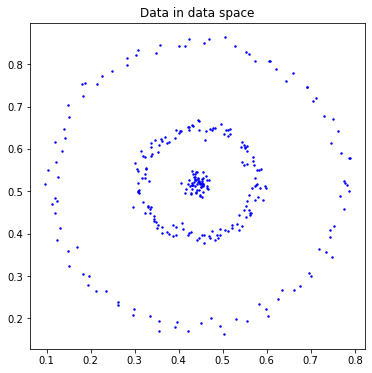

number of data:  299


In [2]:
ori=loadmat('Data/Data2.mat')

n,p=ori['data'].shape

plt.scatter(ori['data'][:,0],ori['data'][:,1], s=2, c="blue")
plt.title("Data in data space")
plt.gcf().set_size_inches(6,6)
#plt.savefig('1.png')
plt.show()

print('number of data: ',n)

### 3. Define functions

In [3]:
def diffuse(data):
    
    K = get_K(data)      #K, the affinity matrix 
    D,Q = get_DnQ(K)     #Q, the normalize affinity matrix
    Z = get_eig(Q, D)    #Z, the eigenvectors of Q
    Y = get_Y(Z)         #Y, the diffusion map
    labels = get_labels(Y)    #cluster via k-means
    
    return Y, labels

***3.1. Construct the affinity matrix $K$***  

In [4]:
def get_K(data):
    Dis=squareform(pdist(data))
    Dis_sort = sort(Dis,1)    # distance of one point to another arrange in descending power
    Dis=Dis*Dis


    Sigma=diag(1/Dis_sort[:,s+1])
    
    
    K=Sigma.dot(Dis).dot(Sigma)
    K=exp(-K)

    return K

***3.2. Construct the normalize affinity matrix $Q$***  

In [5]:
def get_DnQ(K):
    D=diag(1/sqrt(sum(K, axis=1)))
    Q=D.dot(K).dot(D)
    
    return D, Q

***3.3. Calculate the first $c$ eigenvectors of $Q$***  

Note that the function `scds` is called to compute the largest c singular values and corresponding singular vectors. Since $Q$ is a real symmetric matrix, singular values and non-negative eigenvalues coincide.

In [6]:
def get_eig(Q, D):
    U,S,V=svds(Q, c)
    
    return U[:,::-1]

***3.4. Define the diffusion map $Y$*** 

In [7]:
def get_Y(Z):
    temp=diag(1/sqrt(sum(Z*Z, axis=1)))
    return temp.dot(Z)

***3.5. Cluster via k-means***  

In [8]:
def get_labels(Y):

    kmeans = KMeans(clusters)
    kmeans = kmeans.fit(Y)
    labels = array(kmeans.predict(Y)).reshape(n,1)
    
    return labels

### 4. Set parameters

In [9]:
data=ori['data'] #data set
s = 7            #local scaling parameter
c = 3            #the number of the eigenvalues we computed
clusters = 3     #the number of groups of data

### 5. Calculate the diffusion map and labeling

In [10]:
Y,labels=diffuse(data)

### 6. Display results

***6.1. Data in diffusion space***

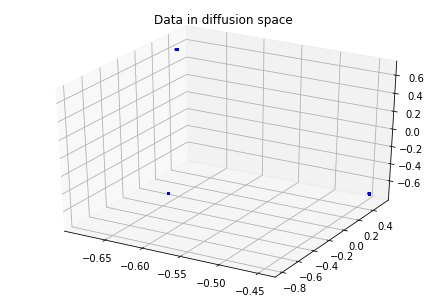

In [11]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Y[:,0],Y[:,1],Y[:,2],s=2, c='b')
plt.title('Data in diffusion space') 
#plt.savefig('2.png')
plt.show()

***6.2. data after labeling***

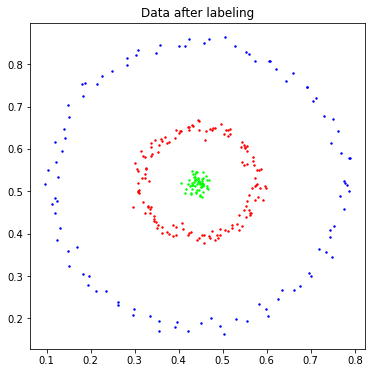

In [12]:
cmap=cm.brg
norm=Normalize(1, clusters)

for i in range(n): plt.scatter(data[i][0], data[i][1], s=2, c=cmap(norm(labels[i]+1)) )
plt.title('Data after labeling')
plt.gcf().set_size_inches(6,6)
#plt.savefig('3.png')
plt.show()

## References

[3] L. Zelnik-Manor and P. Perona, Self-Tuning Spectral Clustering, Advances in Neural Information Processing Systems 17, pp. 1601-1608, 2005, (NIPS’2004)